In [ ]:
!pip install evaluate

In [ ]:
import re
import torch.nn as nn
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, Trainer, TrainingArguments, DataCollatorWithPadding, BertTokenizerFast
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_curve, auc, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
from joblib import Parallel, delayed, parallel_config
import gc
import json
from tqdm.auto import tqdm
import evaluate
import plotly.graph_objects as go

In [ ]:
train_df = pd.read_csv("train_data.csv")
test_texts = pd.read_csv("test_data.csv")

In [ ]:
train_df

,Segmented_Facts,Encoded_Label,Judgment,Type,Document_ID
0,تتلخص وقائع هذه ال دعوى في أن ه سبق أن تقدم وك...,1,حكمت الدائرة حضوريا : أولا : بإلزام المدعى علي...,البيع,4363
1,تتحصل وقائع هذه ال قضي ة من خلال ما قدم ه وكيل...,1,حكمت الدائرة بإلزام المدعى عليه شامي محمد شرقي...,الاجاره,9233
2,تتحصل ال وقائع ب ال قدر ال لازم ل إصدار هذا ال...,0,حكمت الدائرة برفض الدعوى المقامة من المدعية شر...,نظر الدعوى,14921
3,افتقد تلك ال تواريخ مما أحال دون حصول ي على سن...,0,حكمت الدائرة برفض الدعوى المقامة من المدعية شر...,نظر الدعوى,14921
4,و ب سؤال ه عن أن ال عقد محل ال دعوى قيم ت ه ال...,0,حكمت الدائرة برفض الدعوى المقامة من المدعية شر...,نظر الدعوى,14921
...,...,...,...,...,...
45624,تتحصل وقائع هذه ال قضي ة حسبما تبين من مطالع ة...,0,حكمت الدائرة بعدم قبول هذه الدعوى لما هو موضح ...,نظر الدعوى,11483
45625,محل ال اعتراض و ب سؤال ه عن ال قرار لم أرفق ال...,0,حكمت الدائرة بعدم قبول هذه الدعوى لما هو موضح ...,نظر الدعوى,11483
45626,تتلخص واقع ات ال قضي ة ال ماثل ة في أن ال مدعي...,1,حكمت الدائرة بإلزام المدعى عليها شركة وتد المت...,البيع,2667
45627,ف أفهم ت ال دائر ة ال طرف ين أن علي هما تبادل ...,1,حكمت الدائرة بإلزام المدعى عليها شركة وتد المت...,البيع,2667


In [ ]:
test_texts

,Segmented_Facts,Encoded_Label,Judgment,Type,Document_ID
0,تتحصل وقائع هذه ال قضي ة ب ال قدر ال لازم ل إص...,0,حكمت الدائرة بعدم قبول هذه الدعوى لما هو موضح ...,نظر الدعوى,16985
1,ال تجار ة و الذي أشار الى نص ال ماد ة 181 من ن...,0,حكمت الدائرة بعدم قبول هذه الدعوى لما هو موضح ...,نظر الدعوى,16985
2,ل سداد ديون ها و هل ال شرك ة غير متعثر ة ف أجا...,0,حكمت الدائرة بعدم قبول هذه الدعوى لما هو موضح ...,نظر الدعوى,16985
3,تتلخص وقائع هذه ال دعوى في أن ه سبق أن تقدم ال...,0,فلكل ما تقدم ، حكمت المحكمة بــ : عدم اختصاص ا...,نظر الدعوى,10708
4,تتلخص ال دعوى ب ال قدر ال لازم ل ال فصل في ها ...,1,حكمت الدائرة أولا : بإلزام الشركة (…) سجل تجار...,الاجاره,10347
...,...,...,...,...,...
11631,تتحصل وقائع هذه ال دعوى ب ال قدر ال كافي ل إصد...,1,إلزام شركة بمكو العربية للمقاولات سجل تجاري (....,الاجاره,9511
11632,بنكي عبر ال نظام ب تاريخ 29 10 1443 ه و هو عبا...,1,إلزام شركة بمكو العربية للمقاولات سجل تجاري (....,الاجاره,9511
11633,تتلخص وقائع هذه ال دعوى و ب ال قدر ال لازم ل إ...,0,حكمت الدائرة : رفض الدعوى رقم ( ٤٣٩١٦٢٢٤٧ )، و...,نظر الدعوى,15985
11634,ات و أفهم ت ال دائر ة وكيل ال مدعي ة ب إرسال ل...,0,حكمت الدائرة : رفض الدعوى رقم ( ٤٣٩١٦٢٢٤٧ )، و...,نظر الدعوى,15985


In [ ]:
train_df['Sentence_Rank'] = train_df.groupby("Document_ID").cumcount() + 1

In [ ]:
test_texts['Sentence_Rank'] = test_texts.groupby("Document_ID").cumcount() + 1

In [ ]:
test_texts

,Segmented_Facts,Encoded_Label,Judgment,Type,Document_ID,Sentence_Rank
0,تتحصل وقائع هذه ال قضي ة ب ال قدر ال لازم ل إص...,0,حكمت الدائرة بعدم قبول هذه الدعوى لما هو موضح ...,نظر الدعوى,16985,1
1,ال تجار ة و الذي أشار الى نص ال ماد ة 181 من ن...,0,حكمت الدائرة بعدم قبول هذه الدعوى لما هو موضح ...,نظر الدعوى,16985,2
2,ل سداد ديون ها و هل ال شرك ة غير متعثر ة ف أجا...,0,حكمت الدائرة بعدم قبول هذه الدعوى لما هو موضح ...,نظر الدعوى,16985,3
3,تتلخص وقائع هذه ال دعوى في أن ه سبق أن تقدم ال...,0,فلكل ما تقدم ، حكمت المحكمة بــ : عدم اختصاص ا...,نظر الدعوى,10708,1
4,تتلخص ال دعوى ب ال قدر ال لازم ل ال فصل في ها ...,1,حكمت الدائرة أولا : بإلزام الشركة (…) سجل تجار...,الاجاره,10347,1
...,...,...,...,...,...,...
11631,تتحصل وقائع هذه ال دعوى ب ال قدر ال كافي ل إصد...,1,إلزام شركة بمكو العربية للمقاولات سجل تجاري (....,الاجاره,9511,1
11632,بنكي عبر ال نظام ب تاريخ 29 10 1443 ه و هو عبا...,1,إلزام شركة بمكو العربية للمقاولات سجل تجاري (....,الاجاره,9511,2
11633,تتلخص وقائع هذه ال دعوى و ب ال قدر ال لازم ل إ...,0,حكمت الدائرة : رفض الدعوى رقم ( ٤٣٩١٦٢٢٤٧ )، و...,نظر الدعوى,15985,1
11634,ات و أفهم ت ال دائر ة وكيل ال مدعي ة ب إرسال ل...,0,حكمت الدائرة : رفض الدعوى رقم ( ٤٣٩١٦٢٢٤٧ )، و...,نظر الدعوى,15985,2


In [ ]:
unique_docs = train_df["Document_ID"].unique()

train_ids, val_ids = train_test_split(
    unique_docs,
    test_size=0.20,
    random_state=42,
    stratify=train_df.drop_duplicates("Document_ID")["Encoded_Label"]
)

In [ ]:
train_texts = train_df[train_df["Document_ID"].isin(train_ids)].reset_index(drop=True)
val_texts = train_df[train_df["Document_ID"].isin(val_ids)].reset_index(drop=True)

In [ ]:
val_texts

,Segmented_Facts,Encoded_Label,Judgment,Type,Document_ID,Sentence_Rank
0,تتلخص وقائع هذه ال قضي ة في أن سلطان ال عنزي ب...,0,حكمت الدائرة : بعدم قبول الدعوى . وبالله التوف...,نظر الدعوى,17770,1
1,صور ة من ال وثائق ال مشار إلي ها في ال فقر ة 1...,0,حكمت الدائرة : بعدم قبول الدعوى . وبالله التوف...,نظر الدعوى,17770,2
2,و أفهم ت ال دائر ة وكيل ال مدعي أن هذه ال دعوى...,0,حكمت الدائرة : بعدم قبول الدعوى . وبالله التوف...,نظر الدعوى,17770,3
3,ثم سأل ت ال دائر ة ال مدعي وكال ة عن أسانيد ه ...,0,حكمت الدائرة : بعدم قبول الدعوى . وبالله التوف...,نظر الدعوى,17770,4
4,تتحصل وقائع هذه ال قضي ة حسبما تبين من مطالع ة...,0,حكمت الدائرة : برفض هذه الدعوى ، لما هو موضح ب...,نظر الدعوى,15323,1
...,...,...,...,...,...,...
8922,تتحصل وقائع هذه ال قضي ة ب ال قدر ال لازم ل إص...,0,لذا حكمت الدائرة بعدم قبول الدعوى ؛ لما هو مين...,نظر الدعوى,17655,1
8923,و ب اطلاع ال دائر ة على ملف ال قضي ة قرر ت رفع...,0,لذا حكمت الدائرة بعدم قبول الدعوى ؛ لما هو مين...,نظر الدعوى,17655,2
8924,تتلخص وقائع هذه ال دعوى في أن ه تقدم إلى هذه ا...,1,إلزام مريم حمد صالح أبو حوه ، هوية وطنية (...)...,نظر الدعوى,16097,1
8925,تتلخص وقائع هذه ال دعوى ب ال قدر ال لازم ل ال ...,1,حكمت الدائرة بإلزام المدعى عليها بأن تدفع للمد...,الاجاره,7454,1


~64% Train

~16% Val

~20% Test

In [ ]:
print("Train:", len(train_texts))
print("Val:  ", len(val_texts))
print("Test: ", len(test_texts))

Train: 36702
Val:   8927
Test:  11636


In [ ]:
print(train_texts["Encoded_Label"].value_counts(normalize=True))
print(val_texts["Encoded_Label"].value_counts(normalize=True))
print(test_texts["Encoded_Label"].value_counts(normalize=True))

Encoded_Label
0    0.536074
1    0.463926
Name: proportion, dtype: float64
Encoded_Label
0    0.544192
1    0.455808
Name: proportion, dtype: float64
Encoded_Label
0    0.54022
1    0.45978
Name: proportion, dtype: float64


In [ ]:
print(train_texts["Type"].value_counts())
print(val_texts["Type"].value_counts())
print(test_texts["Type"].value_counts())

Type
نظر الدعوى    18135
الاجاره        9501
البيع          9066
Name: count, dtype: int64
Type
نظر الدعوى    4440
البيع         2277
الاجاره       2210
Name: count, dtype: int64
Type
نظر الدعوى    5664
الاجاره       3175
البيع         2797
Name: count, dtype: int64


In [ ]:
train_doc_ids = set(train_texts["Document_ID"])
val_doc_ids   = set(val_texts["Document_ID"])

# Find overlaps
overlapping_ids = train_doc_ids.intersection(val_doc_ids)


if overlapping_ids:
    print(f" Overlapping Document_IDs found: {len(overlapping_ids)}")
    print(f" Sample of overlaps: {list(overlapping_ids)[:10]}")
else:
    print("No overlapping Document_IDs between train and val sets.")

No overlapping Document_IDs between train and val sets.


In [ ]:
train_texts['Encoded_Label'].value_counts()

,count
Encoded_Label,
0,19675
1,17027


In [ ]:
val_texts['Encoded_Label'].value_counts()

,count
Encoded_Label,
0,4858
1,4069


In [ ]:
test_texts['Encoded_Label'].value_counts()

,count
Encoded_Label,
0,6286
1,5350


In [ ]:
model_name = "aubmindlab/bert-base-arabertv2"
tokenizer = AutoTokenizer.from_pretrained(model_name)

Token indices sequence length is longer than the specified maximum sequence length for this model (514 > 512). Running this sequence through the model will result in indexing errors


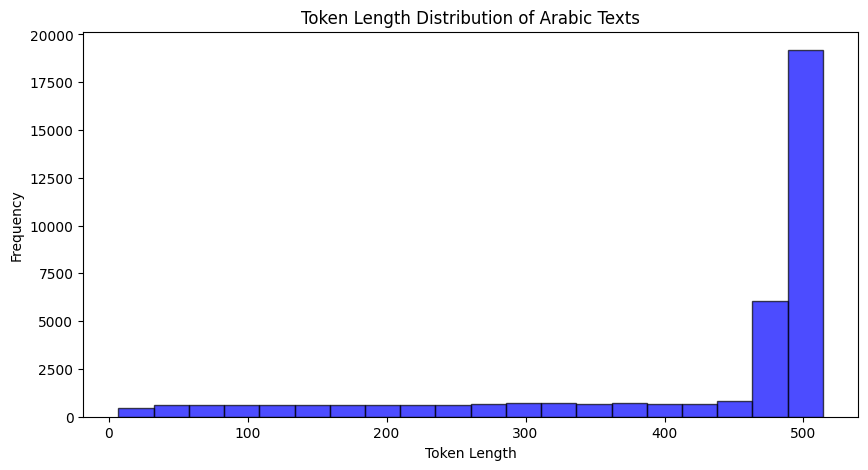

In [ ]:
seq_len = [len(tokenizer.encode(text, truncation=False)) for text in train_texts["Segmented_Facts"].dropna().tolist()]

# Plot histogram
plt.figure(figsize=(10, 5))
plt.hist(seq_len, bins=20, alpha=0.7, color='b', edgecolor='black')
plt.xlabel("Token Length")
plt.ylabel("Frequency")
plt.title("Token Length Distribution of Arabic Texts")
plt.show()

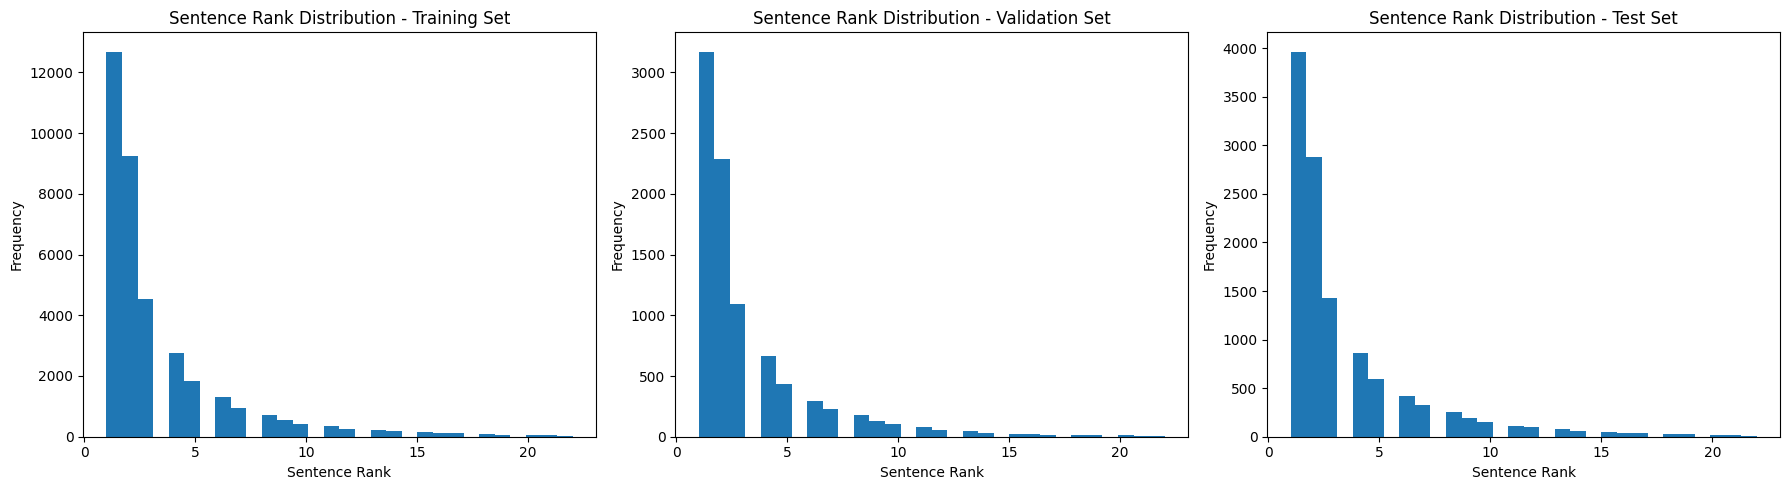

In [ ]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.hist(train_texts["Sentence_Rank"], bins=30)
plt.title("Sentence Rank Distribution - Training Set")
plt.xlabel("Sentence Rank")
plt.ylabel("Frequency")

plt.subplot(1, 3, 2)
plt.hist(val_texts["Sentence_Rank"], bins=30)
plt.title("Sentence Rank Distribution - Validation Set")
plt.xlabel("Sentence Rank")
plt.ylabel("Frequency")

plt.subplot(1, 3, 3)
plt.hist(test_texts["Sentence_Rank"], bins=30)
plt.title("Sentence Rank Distribution - Test Set")
plt.xlabel("Sentence Rank")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

## Sentence-Level

In [ ]:
class LegalDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.data = dataframe.dropna(subset=["Segmented_Facts", "Encoded_Label"])  # Remove NaNs
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = str(self.data.iloc[index]["Segmented_Facts"])
        label = int(self.data.iloc[index]["Encoded_Label"])

        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding=True,  
            truncation=True
        )

        return {
            "input_ids": torch.tensor(encoding["input_ids"], dtype=torch.long).squeeze(),
            "attention_mask": torch.tensor(encoding["attention_mask"], dtype=torch.long).squeeze(),
            "labels": torch.tensor(label, dtype=torch.long)
        }

In [ ]:
#Example
max_tokens = 512
dataset = LegalDataset(test_texts, tokenizer, max_tokens)

print(f"Dataset size: {len(dataset)}\n")

sample = dataset[0]
print("Sample output:")
print("Input IDs:", sample["input_ids"])
print("Attention Mask:", sample["attention_mask"])
print("Label:", sample["labels"])

Dataset size: 11636

Sample output:
Input IDs: tensor([   33, 29785,  5334,   405,   288,  1175,   141,   140,   288,   971,
          288,  2325,   162,  2451,   387,   288,   970,   140,   302,  2549,
          288,  6914,  1074,   140,  3114,   141,  3903,   336,   288,  1290,
          141,   288,  1445,   141,   140,   288,   902,  1075,   289,   298,
          331,  1170,   165,  5183,   288,  6914,   140,   852,   142,   165,
         4024,  1034,   288,  9406,   421,   165,   140,   852,   142,   165,
         4024,   289,   521,   141,  5069,   291, 10535,   288,   833,   141,
          166,   443,   521,   141,   733,   141,  1069,   288,  1749,   141,
          288,  3537,   141,  1795,   298,   288,   902,   166,  1605,  1491,
          298,   288,  1445,   130,   166,   665,   141,   288,  7137,   290,
         1469,   288,  1281,  4772,   130,   166,  1469,  1281,   298,  6322,
           46,  4619,   206,    48,  4619,  6101,  1365,   141,   936,  1436,
          733,   

In [ ]:
max_tokens = 512
train_dataset = LegalDataset(train_texts, tokenizer, max_tokens)
val_dataset = LegalDataset(val_texts, tokenizer, max_tokens)
test_dataset = LegalDataset(test_texts, tokenizer, max_tokens)

In [ ]:
def print_dataset_details(dataset, name):
    print(f"\n{name} Dataset Details:")
    print(f"Number of samples: {len(dataset)}")
    print("\nSample from dataset:")
    sample = dataset[0]  
    print(f"Input IDs: {sample['input_ids']}")
    print(f"Attention Mask: {sample['attention_mask']}")
    print(f"Label: {sample['labels']}")
    print(f"Decoded Text: {tokenizer.decode(sample['input_ids'], skip_special_tokens=True)}")


print_dataset_details(train_dataset, "Train")
print_dataset_details(val_dataset, "Validation")
print_dataset_details(test_dataset, "Test")


Train Dataset Details:
Number of samples: 36702

Sample from dataset:
Input IDs: tensor([   33, 13489,  5334,   405,   288,  3903,   289,   302,   165,  2376,
          302,  1074,  2549,   288,  6914,   288,  2678,   994,   291,   165,
         9557,   165,   140,  1353,   141,  3903,   336,   288,  1290,   141,
          288,  1445,   141,   140,  7272,   935,   289,   298,   302,   877,
          141, 19780,   141,  5150,   142,   407,  8780,   165,   166,   288,
         9406,   421,   298,   140,  3580,   298,  1656,  8780,   165,   288,
         9406,   421,   298,  2213,  2439,   971,   165,  6893,   130,  4619,
          206,  1436,   140,  3580,  1044,  7660,   288,  9381,   288, 10465,
          407,  1900,   168,   288,  3903,   306,  6843,   291,   288,  9406,
          421,   298, 31518,   140,  6165,   298,   166,  2466,  6695,   840,
          298,   130,   161,  1469,  1281,   162,   288,  7663,   141,   140,
          165,   289,  1711,   288,  9381,   166,   288,  16

In [ ]:
class CustomBERTModel(nn.Module):
    def __init__(self, model_name, num_labels):
        super(CustomBERTModel, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)

        #Freeze the bottom 6 layers of BERT
        for name, param in self.bert.named_parameters():
            if name.startswith("encoder.layer.") and int(name.split('.')[2]) < 6:
                param.requires_grad = False

        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_labels)
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, input_ids, attention_mask, labels=None, **kwargs):
        valid_kwargs = {k: v for k, v in kwargs.items() if k in ["token_type_ids", "output_hidden_states", "output_attentions"]}

        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=True, **valid_kwargs)
        cls_output = self.dropout(outputs.pooler_output)  
        logits = self.fc(cls_output)

        loss = None
        if labels is not None:
            loss = self.loss_fn(logits, labels)

        return {"logits": logits, "loss": loss}


model = CustomBERTModel(model_name="aubmindlab/bert-base-arabertv2", num_labels=2)

In [ ]:
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average="weighted")
    return {"accuracy": acc, "f1_score": f1}

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=8,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
    load_best_model_at_end=True,
    fp16=True,
    warmup_ratio=0.06,
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

<ipython-input-140-d1551555b382>:2: FutureWarning:

`tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.



In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
# NEW
train_output = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1 Score
1,0.571500,0.512515,0.733169,0.733663
2,0.464900,0.514265,0.751988,0.752416
3,0.456500,0.497525,0.764535,0.763417
4,0.309800,0.540090,0.747172,0.747666
5,0.331100,0.600766,0.747284,0.747635
6,0.206500,0.742209,0.754901,0.753109
7,0.127500,0.838099,0.744035,0.744352
8,0.202200,0.907995,0.745603,0.745783


In [ ]:
predictions = trainer.predict(test_dataset)

In [ ]:
logits = predictions.predictions
probs = torch.softmax(torch.tensor(logits), dim=-1).numpy()

predicted_labels = np.argmax(probs, axis=1)
confidence_scores = np.max(probs, axis=1)

In [ ]:
test_texts["Sentence_Predicted_Label"] = predicted_labels
test_texts["Sentence_Confidence"] = confidence_scores

In [ ]:
test_texts

,Segmented_Facts,Encoded_Label,Judgment,Type,Document_ID,Sentence_Rank,Sentence_Predicted_Label,Sentence_Confidence
0,تتحصل وقائع هذه ال قضي ة ب ال قدر ال لازم ل إص...,0,حكمت الدائرة بعدم قبول هذه الدعوى لما هو موضح ...,نظر الدعوى,16985,1,0,0.969814
1,ال تجار ة و الذي أشار الى نص ال ماد ة 181 من ن...,0,حكمت الدائرة بعدم قبول هذه الدعوى لما هو موضح ...,نظر الدعوى,16985,2,0,0.939359
2,ل سداد ديون ها و هل ال شرك ة غير متعثر ة ف أجا...,0,حكمت الدائرة بعدم قبول هذه الدعوى لما هو موضح ...,نظر الدعوى,16985,3,0,0.966820
3,تتلخص وقائع هذه ال دعوى في أن ه سبق أن تقدم ال...,0,فلكل ما تقدم ، حكمت المحكمة بــ : عدم اختصاص ا...,نظر الدعوى,10708,1,0,0.871966
4,تتلخص ال دعوى ب ال قدر ال لازم ل ال فصل في ها ...,1,حكمت الدائرة أولا : بإلزام الشركة (…) سجل تجار...,الاجاره,10347,1,1,0.849847
...,...,...,...,...,...,...,...,...
11631,تتحصل وقائع هذه ال دعوى ب ال قدر ال كافي ل إصد...,1,إلزام شركة بمكو العربية للمقاولات سجل تجاري (....,الاجاره,9511,1,0,0.573604
11632,بنكي عبر ال نظام ب تاريخ 29 10 1443 ه و هو عبا...,1,إلزام شركة بمكو العربية للمقاولات سجل تجاري (....,الاجاره,9511,2,1,0.707203
11633,تتلخص وقائع هذه ال دعوى و ب ال قدر ال لازم ل إ...,0,حكمت الدائرة : رفض الدعوى رقم ( ٤٣٩١٦٢٢٤٧ )، و...,نظر الدعوى,15985,1,0,0.769600
11634,ات و أفهم ت ال دائر ة وكيل ال مدعي ة ب إرسال ل...,0,حكمت الدائرة : رفض الدعوى رقم ( ٤٣٩١٦٢٢٤٧ )، و...,نظر الدعوى,15985,2,1,0.770486


In [ ]:
train_predictions = trainer.predict(train_dataset)
train_logits = train_predictions.predictions
train_probs = torch.softmax(torch.tensor(train_logits), dim=-1).numpy()

train_predicted_labels = np.argmax(train_probs, axis=1)
train_confidence_scores = np.max(train_probs, axis=1)

train_texts["Sentence_Predicted_Label"] = train_predicted_labels
train_texts["Sentence_Confidence"] = train_confidence_scores

val_predictions = trainer.predict(val_dataset)
val_logits = val_predictions.predictions
val_probs = torch.softmax(torch.tensor(val_logits), dim=-1).numpy()

val_predicted_labels = np.argmax(val_probs, axis=1)
val_confidence_scores = np.max(val_probs, axis=1)

val_texts["Sentence_Predicted_Label"] = val_predicted_labels
val_texts["Sentence_Confidence"] = val_confidence_scores

In [ ]:
test_texts['Sentence_Confidence'].min()

0.5

In [ ]:
test_texts['Sentence_Confidence'].max()

0.9848692417144775

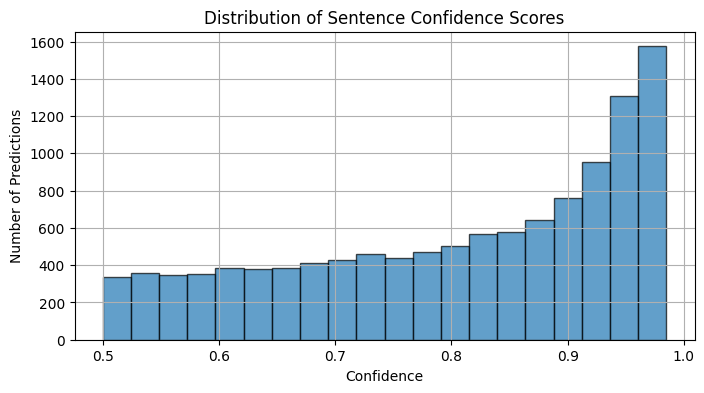

In [ ]:
plt.figure(figsize=(8, 4))
plt.hist(test_texts["Sentence_Confidence"], bins=20, edgecolor='black', alpha=0.7)
plt.title("Distribution of Sentence Confidence Scores")
plt.xlabel("Confidence")
plt.ylabel("Number of Predictions")
plt.grid(True)
plt.show()

In [ ]:
avg_conf_per_rank = test_texts.groupby("Sentence_Rank")["Sentence_Confidence"].mean()
print(avg_conf_per_rank)

Sentence_Rank
1     0.838693
2     0.812131
3     0.787991
4     0.776241
5     0.772144
6     0.764087
7     0.766915
8     0.768984
9     0.768287
10    0.766493
11    0.769041
12    0.754201
13    0.730704
14    0.765520
15    0.727522
16    0.745693
17    0.765725
18    0.775939
19    0.765462
20    0.746179
21    0.766196
22    0.758001
Name: Sentence_Confidence, dtype: float32


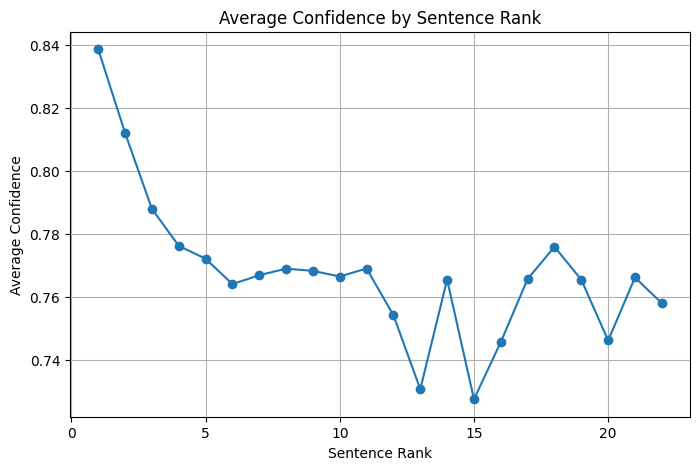

In [ ]:
avg_conf_per_rank.plot(kind='line', marker='o', figsize=(8, 5), title="Average Confidence by Sentence Rank")
plt.xlabel("Sentence Rank")
plt.ylabel("Average Confidence")
plt.grid(True)
plt.show()

In [ ]:
df = test_texts.copy()

In [ ]:
last_rank_map = df.groupby("Document_ID")["Sentence_Rank"].max().to_dict()

def get_position(row):
    max_rank = last_rank_map[row["Document_ID"]]

    if max_rank == 1:
        return "Middle"

    first_cutoff = int(max_rank * 0.3)
    last_cutoff = int(max_rank * 0.7) + 1

    if row["Sentence_Rank"] <= first_cutoff:
        return "First"
    elif row["Sentence_Rank"] >= last_cutoff:
        return "Last"
    else:
        return "Middle"

df["Position"] = df.apply(get_position, axis=1)

avg_conf_by_position = df.groupby("Position")["Sentence_Confidence"].mean().reset_index()

avg_conf_by_position["Position"] = pd.Categorical(avg_conf_by_position["Position"], ["First", "Middle", "Last"])
avg_conf_by_position = avg_conf_by_position.sort_values("Position")

In [ ]:
fig = px.bar(
    avg_conf_by_position,
    x="Position",
    y="Sentence_Confidence",
    title="Average Confidence by Sentence Position",
    labels={"Sentence_Confidence": "Average Confidence"},
    color="Position",
    color_discrete_sequence=["#5DADE2", "#3498DB", "#2E86C1"])

fig.update_layout(
    yaxis=dict(range=[0, 1]),
    template="plotly_white")
fig.show()

In [ ]:
last_rank_map = df.groupby("Document_ID")["Sentence_Rank"].max().to_dict()

def get_position(row):
    max_rank = last_rank_map[row["Document_ID"]]

    if max_rank == 1:
        return "First"

    first_cutoff = int(max_rank * 0.3)
    last_cutoff = int(max_rank * 0.7) + 1

    if row["Sentence_Rank"] <= first_cutoff:
        return "First"
    elif row["Sentence_Rank"] >= last_cutoff:
        return "Last"
    else:
        return "Middle"


df["Position"] = df.apply(get_position, axis=1)


avg_conf_by_position = df.groupby("Position")["Sentence_Confidence"].mean().reset_index()


avg_conf_by_position["Position"] = pd.Categorical(avg_conf_by_position["Position"], ["First", "Middle", "Last"])
avg_conf_by_position = avg_conf_by_position.sort_values("Position")

In [ ]:
fig = px.bar(
    avg_conf_by_position,
    x="Position",
    y="Sentence_Confidence",
    title="Average Confidence by Sentence Position",
    labels={"Sentence_Confidence": "Average Confidence"},
    color="Position",
    color_discrete_sequence=["#5DADE2", "#3498DB", "#2E86C1"])

fig.update_layout(
    yaxis=dict(range=[0, 1]),
    template="plotly_white")
fig.show()

In [ ]:
type_confidence = test_texts.groupby("Type")["Sentence_Confidence"].mean().reset_index()

type_confidence = type_confidence.sort_values(by="Sentence_Confidence", ascending=False)

fig = px.bar(
    type_confidence,
    x="Type",
    y="Sentence_Confidence",
    title="Average Confidence by Case Type",
    labels={"Confidence": "Average Confidence"},
    color="Sentence_Confidence",
    color_continuous_scale="Blues"
)

fig.update_layout(xaxis_title="Case Type", yaxis_title="Average Confidence")
fig.show()

In [ ]:
test_texts["Is_Correct"] = test_texts["Encoded_Label"] == test_texts["Sentence_Predicted_Label"]

wrong_counts = test_texts[~test_texts["Is_Correct"]] \
    .groupby("Type") \
    .size() \
    .reset_index(name="Wrong_Predictions")

total_counts = test_texts.groupby("Type") \
    .size() \
    .reset_index(name="Total_Cases")

merged_counts = pd.merge(wrong_counts, total_counts, on="Type", how="left")

merged_counts["Wrong_Percentage"] = (merged_counts["Wrong_Predictions"] / merged_counts["Total_Cases"]) * 100

merged_counts = merged_counts.sort_values(by="Wrong_Percentage", ascending=False)

print("Incorrect Predictions by Case Type (Percentage Based):\n")
print(merged_counts.to_string(index=False))

Incorrect Predictions by Case Type (Percentage Based):

      Type  Wrong_Predictions  Total_Cases  Wrong_Percentage
   الاجاره                964         3175         30.362205
     البيع                787         2797         28.137290
نظر الدعوى               1229         5664         21.698446


In [ ]:
fig = px.bar(
    wrong_counts,
    x="Type",
    y="Wrong_Predictions",
    title="Wrong Predictions by Case Type",
    labels={"Type": "Case Type", "Wrong_Predictions": "Count of Incorrect Predictions"},
    color="Wrong_Predictions",
    color_continuous_scale="OrRd"
)

fig.update_layout(xaxis_tickangle=-45, template="plotly_white")
fig.show()

In [ ]:
# Plot
fig = px.bar(
    merged_counts,
    x="Wrong_Percentage",
    y="Type",
    orientation="h",
    title="Wrong Prediction Percentage by Case Type",
    labels={"Wrong_Percentage": "Wrong Prediction (%)", "Type": "Case Type"},
    text="Wrong_Percentage"
)

fig.update_traces(texttemplate='%{text:.2f}%', textposition='outside')
fig.update_layout(
    yaxis=dict(autorange="reversed"),
    xaxis_title="Wrong Prediction Percentage (%)",
    yaxis_title="Case Type",
    plot_bgcolor="white"
)
fig.show()

In [ ]:
test_texts.to_csv("testset_with_Sentence_predictions.csv", index=False)

In [ ]:
val_texts.to_csv("valset_with_Sentence_predictions.csv", index=False)

In [ ]:
train_texts.to_csv("trainset_with_Sentence_predictions.csv", index=False)